# Getting Started with ctapipe

This hands-on was presented at the Paris CTA Consoritum meeting (K. Kosack)

## Part 1: load and loop over data

In [1]:
from ctapipe.io import EventSource
from ctapipe import utils
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
path = utils.get_dataset_path("gamma_test_large.simtel.gz")

In [3]:
source = EventSource(path, max_events=4)

for event in source:
    print(event.count, event.index.event_id, event.simulation.shower.energy)

0 23703 0.5707105398178101 TeV
1 31007 1.8637498617172241 TeV
2 31010 1.8637498617172241 TeV
3 31012 1.8637498617172241 TeV


In [4]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: DL2 reconstruction info
                  simulation.*: Simulated Event Information
                     trigger.*: central trigger information
                         count: number of events processed
                    pointing.*: Array and telescope pointing positions
                 calibration.*: Container for calibration coefficients for the
                                current event
                         mon.*: container for event-wise monitoring data (MON)

In [5]:
event.r0

ctapipe.containers.R0Container:
                        tel[*]: map of tel_id to R0CameraContainer

In [6]:
for event in EventSource(path, max_events=4):
    print(event.count, event.r0.tel.keys())

0 dict_keys([13, 21, 25, 34])
1 dict_keys([7, 13, 16, 19, 25, 28, 34, 36, 42])
2 dict_keys([28, 46, 58, 68])
3 dict_keys([2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21])


In [7]:
event.r0.tel[2]

ctapipe.containers.R0CameraContainer:
                      waveform: numpy array containing ADC samples(n_channels,
                                n_pixels, n_samples)

In [8]:
r0tel = event.r0.tel[3]

In [9]:
r0tel.waveform

array([[[267, 288, 286, ..., 297, 298, 312],
        [293, 285, 258, ..., 344, 373, 365],
        [333, 319, 289, ..., 306, 272, 261],
        ...,
        [255, 261, 270, ..., 258, 269, 271],
        [277, 312, 277, ..., 294, 323, 376],
        [319, 300, 347, ..., 283, 302, 265]],

       [[295, 304, 299, ..., 299, 298, 299],
        [298, 297, 300, ..., 300, 307, 304],
        [301, 305, 300, ..., 303, 300, 297],
        ...,
        [297, 296, 301, ..., 295, 297, 298],
        [295, 301, 296, ..., 300, 305, 302],
        [298, 300, 302, ..., 302, 297, 301]]], dtype=uint16)

In [10]:
r0tel.waveform.shape

(2, 1855, 30)

note that this is ($N_{channels}$, $N_{pixels}$, $N_{samples}$)

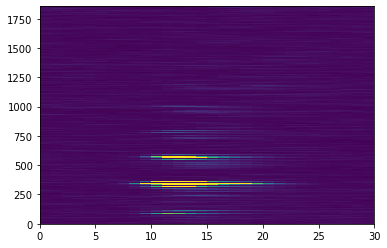

In [11]:
plt.pcolormesh(r0tel.waveform[0])

In [12]:
brightest_pixel = np.argmax(r0tel.waveform[0].sum(axis=1))
print(f"pixel {brightest_pixel} has sum {r0tel.waveform[0,1535].sum()}")

pixel 344 has sum 8642


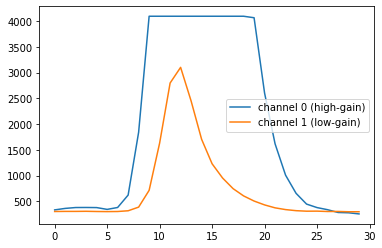

In [13]:
plt.plot(r0tel.waveform[0,brightest_pixel], label="channel 0 (high-gain)")
plt.plot(r0tel.waveform[1,brightest_pixel], label="channel 1 (low-gain)")
plt.legend()

In [14]:
from ipywidgets import interact

@interact
def view_waveform(chan=0, pix_id=brightest_pixel):
    plt.plot(r0tel.waveform[chan, pix_id])

interactive(children=(IntSlider(value=0, description='chan', max=1), IntSlider(value=344, description='pix_id'…

try making this compare 2 waveforms

## Part 2: Explore the instrument description
This is all well and good, but we don't really know what camera or telescope this is... how do we get instrumental description info?

Currently this is returned *inside* the event (it will soon change to be separate in next version or so)

In [15]:
subarray = source.subarray 

In [16]:
subarray

SubarrayDescription(name='MonteCarloArray', num_tels=98)

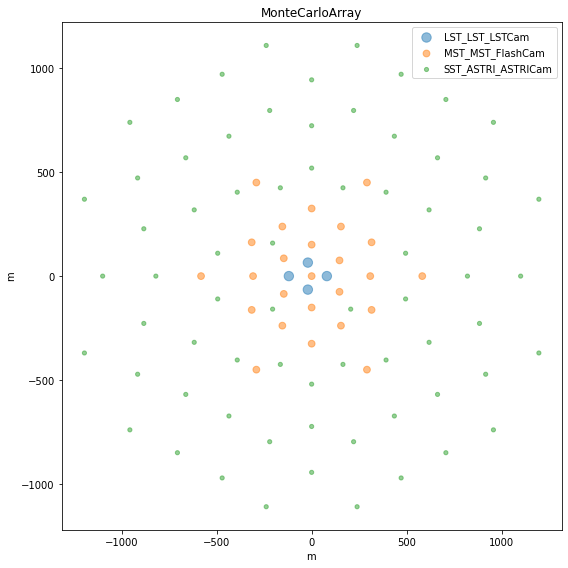

In [17]:
subarray.peek()

In [18]:
subarray.to_table()

tel_id,pos_x,pos_y,pos_z,name,type,camera_type,camera_index,optics_index,tel_description
,m,m,m,,,,,,
int16,float64,float64,float64,str5,str3,str8,int64,int64,str18
1,-20.0,65.0,16.0,LST,LST,LSTCam,1,0,LST_LST_LSTCam
2,-20.0,-65.0,16.0,LST,LST,LSTCam,1,0,LST_LST_LSTCam
3,80.0,0.0,16.0,LST,LST,LSTCam,1,0,LST_LST_LSTCam
4,-120.0,0.0,16.0,LST,LST,LSTCam,1,0,LST_LST_LSTCam
5,0.0,0.0,10.0,MST,MST,FlashCam,0,1,MST_MST_FlashCam
6,0.0,151.1999969482422,10.0,MST,MST,FlashCam,0,1,MST_MST_FlashCam
7,0.0,-151.1999969482422,10.0,MST,MST,FlashCam,0,1,MST_MST_FlashCam
8,146.65599060058594,75.5999984741211,10.0,MST,MST,FlashCam,0,1,MST_MST_FlashCam


In [19]:
subarray.tel[2]

TelescopeDescription(type=LST, name=LST, optics=LST, camera=LSTCam)

In [20]:
subarray.tel[2].camera

CameraDescription(camera_name=LSTCam, geometry=LSTCam, readout=LSTCam)

In [21]:
subarray.tel[2].optics

OpticsDescription(name=LST, equivalent_focal_length=28.00 m, num_mirrors=1, mirror_area=386.73 m2)

In [22]:
tel = subarray.tel[2]

In [23]:
tel.camera

CameraDescription(camera_name=LSTCam, geometry=LSTCam, readout=LSTCam)

In [24]:
tel.optics

OpticsDescription(name=LST, equivalent_focal_length=28.00 m, num_mirrors=1, mirror_area=386.73 m2)

In [25]:
tel.camera.geometry.pix_x

<Quantity [ 0.        , -0.00944877, -0.0472442 , ..., -0.6519913 ,
           -0.6141959 , -0.62364468] m>

In [26]:
tel.camera.geometry.to_table()

pix_id,pix_x,pix_y,pix_area
,m,m,m2
int64,float64,float64,float64
0,0.0,0.0,0.002079326892271638
1,-0.00944877371419763,0.049099091130118636,0.002079326892271638
2,-0.04724419824666762,0.01636690782283136,0.002079326892271638
3,-0.037795424532469986,-0.03273218330728728,0.002079326892271638
4,0.00944877371419763,-0.049099091130118636,0.002079326892271638
5,0.04724419824666762,-0.01636690782283136,0.002079326892271638
6,0.037795424532469986,0.03273218330728728,0.002079326892271638
7,0.06614174532306863,-0.11456508825398498,0.002079326892271638


In [27]:
tel.optics.mirror_area

<Quantity 386.73324585 m2>

In [28]:
from ctapipe.visualization import CameraDisplay

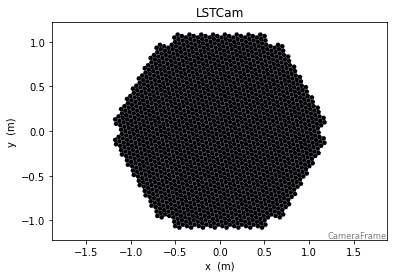

In [29]:
disp = CameraDisplay(tel.camera.geometry)

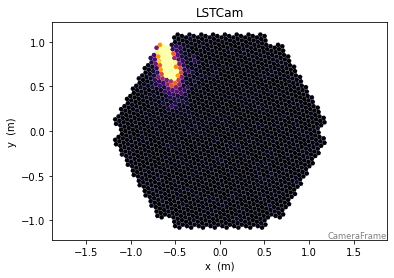

In [30]:
disp = CameraDisplay(tel.camera.geometry)
disp.image = r0tel.waveform[0,:,10]  # display channel 0, sample 0 (try others like 10)

 ** aside: ** show demo using a CameraDisplay in interactive mode in ipython rather than notebook

## Part 3: Apply some calibration and trace integration

In [31]:
from ctapipe.calib import CameraCalibrator

In [32]:
calib = CameraCalibrator(subarray=subarray)

In [33]:
for event in EventSource(path, max_events=4):
    calib(event) # fills in r1, dl0, and dl1
    print(event.dl1.tel.keys())

dict_keys([13, 21, 25, 34])
dict_keys([7, 13, 16, 19, 25, 28, 34, 36, 42])
dict_keys([28, 46, 58, 68])


dict_keys([2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21])


In [34]:
event.dl1.tel[3]

ctapipe.containers.DL1CameraContainer:
                         image: Numpy array of camera image, after waveform
                                extraction.Shape: (n_pixel) as a 1-D array with
                                type float32
                     peak_time: Numpy array containing position of the peak of
                                the pulse as determined by the extractor. Shape:
                                (n_pixel, ) as a 1-D array with type float32
                    image_mask: Boolean numpy array where True means the pixel
                                has passed cleaning. Shape: (n_pixel, ) as a 1-D
                                array with type bool
                      is_valid: True if image extraction succeeded, False if
                                failed or in the case of TwoPass methods, that
                                the first pass only was returned.
                    parameters: Image parameters

In [35]:
dl1tel = event.dl1.tel[3]

In [36]:
dl1tel.image.shape # note this will be gain-selected in next version, so will be just 1D array of 1855

(1855,)

In [37]:
dl1tel.peak_time

array([34.26634 , 49.123714, 37.32338 , ..., 50.50625 , 45.477562,
       42.10054 ], dtype=float32)

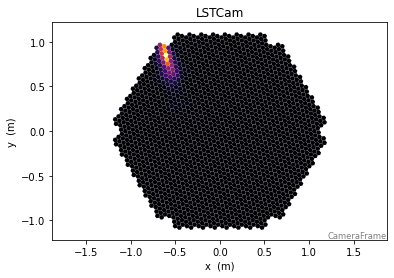

In [38]:
CameraDisplay(tel.camera.geometry, image=dl1tel.image)

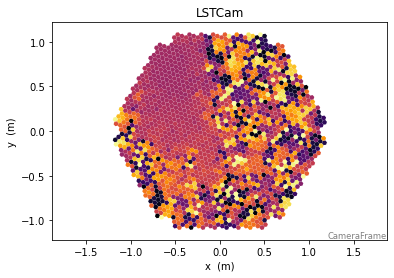

In [39]:
CameraDisplay(tel.camera.geometry, image=dl1tel.peak_time)

Now for Hillas Parameters

In [40]:
from ctapipe.image import hillas_parameters, tailcuts_clean

In [41]:
image = dl1tel.image
mask = tailcuts_clean(tel.camera.geometry, image, picture_thresh=10, boundary_thresh=5)
mask

array([False, False, False, ..., False, False, False])

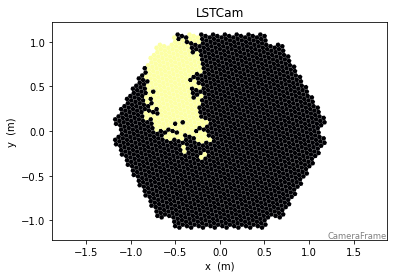

In [42]:
CameraDisplay(tel.camera.geometry, image=mask)

In [43]:
cleaned = image.copy()
cleaned[~mask] = 0 

(0.0, 1.0)

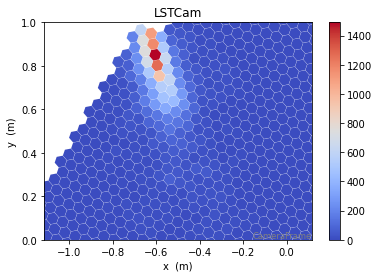

In [44]:
disp = CameraDisplay(tel.camera.geometry, image=cleaned)
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
plt.xlim(-1.0,0)
plt.ylim(0,1.0)

In [45]:
params = hillas_parameters(tel.camera.geometry, cleaned)
print(params)

{'intensity': 24075.39680337906,
 'kurtosis': 6.097240958638256,
 'length': <Quantity 0.20667421 m>,
 'length_uncertainty': <Quantity 0.00150362 m>,
 'phi': <Angle 2.23935833 rad>,
 'psi': <Angle -1.32341913 rad>,
 'r': <Quantity 0.92739417 m>,
 'skewness': 1.602462697612408,
 'width': <Quantity 0.07996111 m>,
 'width_uncertainty': <Quantity 0.00059966 m>,
 'x': <Quantity -0.57485289 m>,
 'y': <Quantity 0.72773903 m>}


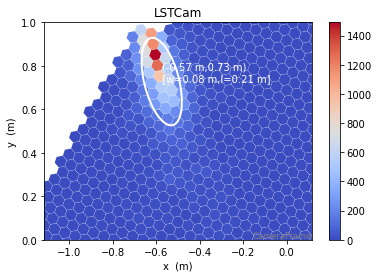

In [46]:
disp = CameraDisplay(tel.camera.geometry, image=cleaned)
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
plt.xlim(-1.0,0)
plt.ylim(0,1.0)
disp.overlay_moments(params, color='white', lw=2)

## Part 4:  Let's put it all together: 
- loop over events, selecting only telescopes of the same type (e.g. LST:LSTCam)
- for each event, apply calibration/trace integration
- calculate Hillas parameters 
- write out all hillas paremeters to a file that can be loaded with Pandas

first let's select only those telescopes with LST:LSTCam

In [47]:
subarray.telescope_types

[TelescopeDescription(type=LST, name=LST, optics=LST, camera=LSTCam),
 TelescopeDescription(type=MST, name=MST, optics=MST, camera=FlashCam),
 TelescopeDescription(type=SST, name=ASTRI, optics=ASTRI, camera=ASTRICam)]

In [48]:
subarray.get_tel_ids_for_type("LST_LST_LSTCam")

[1, 2, 3, 4]

Now let's write out program

In [49]:
data = utils.get_dataset_path("gamma_test_large.simtel.gz") 
source = EventSource(data, allowed_tels=[1,2,3,4],  max_events=10) # remove the max_events limit to get more stats

In [50]:
for event in source:
    calib(event)
    
    for tel_id, tel_data in event.dl1.tel.items():
        tel = source.subarray.tel[tel_id]
        mask = tailcuts_clean(tel.camera.geometry, tel_data.image)
        params = hillas_parameters(tel.camera.geometry[mask], tel_data.image[mask])

In [51]:
from ctapipe.io import HDF5TableWriter


In [52]:
with HDF5TableWriter(filename='hillas.h5', group_name='dl1', overwrite=True) as writer:
    
    source = EventSource(data, allowed_tels=[1,2,3,4],  max_events=10)
    for event in source:
        calib(event)
    
        for tel_id, tel_data in event.dl1.tel.items():
            tel = source.subarray.tel[tel_id]
            mask = tailcuts_clean(tel.camera.geometry, tel_data.image)
            params = hillas_parameters(tel.camera.geometry[mask], tel_data.image[mask])
            writer.write("hillas", params)

### We can now load in the file we created and plot it

In [53]:
!ls *.h5

hillas.h5


In [54]:
import pandas as pd

hillas = pd.read_hdf("hillas.h5", key='/dl1/hillas')
hillas

,intensity,skewness,kurtosis,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi
0,487.476215,0.321630,2.002041,-0.972286,0.384784,1.045657,158.408735,0.242312,0.005493,0.046845,1.493808e-03,63.145178
1,24235.389950,1.663777,6.299195,-0.573681,0.723743,0.923533,128.402429,0.214123,0.001583,0.083103,6.703856e-04,-75.990548
2,81.252289,0.463036,2.797550,0.563962,0.712100,0.908372,51.621855,0.045043,0.003350,0.015390,9.838555e-04,63.564682
3,101.234468,0.206285,2.098711,0.340860,0.896085,0.958725,69.173821,0.051080,0.002661,0.020644,1.047590e-03,81.540893
4,76.273210,-0.310947,2.766870,-0.457182,0.851789,0.966727,118.223829,0.044145,0.003359,0.020285,1.321683e-03,73.286384
5,30.754364,-0.060794,2.277771,-0.658798,0.686477,0.951455,133.821326,0.033088,0.003372,0.000001,3.615390e-08,-19.104678
6,148.823297,1.325198,5.088021,-1.010522,0.264090,1.044461,165.353912,0.107545,0.008912,0.035770,1.909823e-03,40.042441
7,263.484926,0.437843,2.732760,-1.007649,-0.031596,1.008144,-178.204001,0.061533,0.002495,0.047032,2.086092e-03,-13.703852
8,92.449732,1.970612,5.054535,-0.656211,0.144985,0.672037,167.541102,0.413698,0.043318,0.029936,1.439745e-03,15.975587
9,108.459053,0.802975,2.236590,-1.109201,0.179422,1.123619,170.811523,0.100173,0.005348,0.019330,9.515764e-04,48.966843


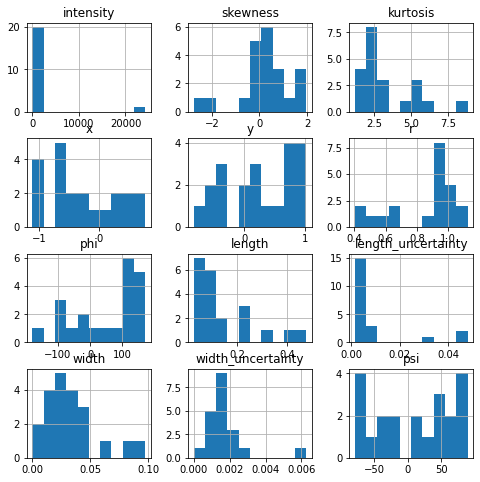

In [55]:
_ = hillas.hist(figsize=(8,8))

If you do this yourself, loop over more events to get better statistics